In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR


import os
import numpy as np

from Stage1.modelsMultitalk.stage1_vocaset import VQAutoEncoder
from Stage1.metrics.loss import calc_vq_loss
from Stage1.base.utilities import AverageMeter
#from Stage1.funciones import IntraDataset
from funciones import IntraDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class Args:
    def __init__(self):
        # LOSS settings
        self.quant_loss_weight = 1.

        # NETWORK settings
        #self.arch = 'stage1_vocaset'
        self.in_dim = 39
        self.hidden_size = 1024
        self.num_hidden_layers = 6
        self.num_attention_heads = 8
        self.intermediate_size = 1536
        self.window_size = 1
        self.quant_factor = 0
        self.face_quan_num = 16
        self.neg = 0.2
        self.INaffine = False

        # VQuantizer settings
        self.n_embed = 256
        self.zquant_dim = 64#64 

        # TRAIN settings
        self.use_sgd = False
        self.sync_bn = False  # adopt sync_bn or not
        self.train_gpu = [0]
        self.workers = 10  # data loader workers
        self.batch_size = 1  # batch size for training
        self.batch_size_val = 1  # batch size for validation during training
        self.base_lr = 0.0001
        self.StepLR = True
        self.warmup_steps = 1
        self.adaptive_lr = False
        self.factor = 0.3
        self.patience = 3
        self.threshold = 0.0001
        self.poly_lr = False
        self.epochs = 200
        self.step_size = 200
        self.gamma = 0.9
        self.start_epoch = 0
        self.power = 0.9
        self.momentum = 0.9
        self.weight_decay = 0.002
        self.manual_seed = 131

        ##stage 2
        self.device = 'cuda'  # or 'cpu'
        self.dataset = 'BIWI'  # or 'multi' depending on your dataset
        self.wav2vec2model_path = 'path/to/wav2vec2model'  # path to pretrained Wav2Vec2 model
        self.feature_dim = 1024  # dimension for the feature after audio encoding
        self.vertice_dim = 31  # number of vertices * 3 (e.g., V * 3 for 3D coordinates)
        self.n_head = 8  # number of attention heads in the transformer decoder
        self.num_layers = 6  # number of layers in the transformer decoder
        self.period = 2#100  # period for positional encoding
        #self.face_quan_num = 16  # quantization levels per face/vertex
        #self.zquant_dim = 64  # dimension of the quantized latent space
        self.vqvae_pretrained_path = 'modelos-entrenados/fast-bee.pth'  # path to pretrained VQ-VAE
        self.train_subjects = 'subject1 subject2 subject3'  # space-separated list of subjects used in training
        self.motion_weight = 1.0  # weight for the motion loss
        self.reg_weight = 0.1  # weight for the regularization loss
        self.batch_size = 1#32  # batch size for training
        #self.epochs = 100  # number of training epochs
        #self.base_lr = 0.0001  # base learning rate
        self.gpu = torch.cuda.current_device()

# Instantiate the arguments
args = Args()


In [28]:
def load_file_list(txt_path):
    with open(txt_path, 'r') as f:
        return [line.strip() for line in f]

val_files = load_file_list("splits/train_files.txt")
root_dir = "Data/Aneux+Intra-splines"
val_dataset = IntraDataset(val_files, mode = "post_order", p=15, root_dir=root_dir, val = True) #mode es el modo al que quiero que transforme
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

Dataset size: 994


In [5]:
checkpoint = torch.load("models/stage1/aneux/best-model-aneux15-zero-root.pth")

#checkpoint = torch.load("modelos-entrenados/elated-surf.pth", map_location= "cuda:0")
model = VQAutoEncoder(args).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['loss']
print(checkpoint['epoch'])

949


In [6]:
arboles_generados = {}
for input, file_name in val_loader:
    with torch.no_grad():  # No need to compute gradients during sampling
        if input.shape[1] > 1:
            input = input.to(device)
            generated_tree, quantized_tree = model.sample_step(input.to(device))
            arboles_generados[file_name] = generated_tree


In [7]:
from collections import defaultdict
from funciones import Tree

def deserialize_post_order(serial):

    serial = serial.copy()

    def post_order(serial):

        if serial[-39:] == list([0.0] * 39):
            for i in range(39): serial.pop()
            return None
        
        data = defaultdict(list)
        for i in range(39):
            data["r"].append(serial.pop())
       

        tree = Tree(data)

        tree.right = post_order(serial)
        tree.left = post_order(serial)
        
        return tree    
    
    return post_order(serial)

def deserialize_pre_order(serial):
    
    #serial = serial.copy()
    if  not serial:
        return 
    nodes = serial.split(';') 
    def post(serial):
        if len(serial) > 0:
            dat = serial[0].split("_")[1]
            if dat != str([0.0] * 39):
                data = defaultdict(list)
                g = dat.split(",")
                g [0] = g[0].replace('[','')
                g[-1] = g[-1].replace(']','')
                for i in range(39):
                    data["r"].append(g.pop(0))
                
                tree = Tree(data)

                left, ret = post(serial[1:])
                right, ret = post(ret)

                tree.left = left
                tree.right = right

                return tree, ret

            else:
                return None, serial[1:]
            
        #else:
        #    return None, []
    return post(nodes)

def serialize_post_order(tree):

    def post_order(tree):

        if tree:

            post_order(tree.left)
            post_order(tree.right)

            #ret[0] += '1_'+ str([np.round(float(v), 39) for v in list(tree.data.values())]) +';'
            ret[0] += '1_'+ str(list(map(float, list(tree.data.values())[0]))) +';'

        else:
            ret[0] += '#;'

    ret = ['']
    post_order(tree)
    return ret[0][:-1]

def serialize_post_order_numpy_vector(tree):
    features = []

    def post_order(node):
        if node:
            post_order(node.left)
            post_order(node.right)
            features.append(list(map(float, list(node.data.values())[0])))  # Convert to float list and append
        else:
            features.append([0.0] * 39)

    post_order(tree)
    
    return np.array(features, dtype=np.float32)  # Convert to NumPy array

def serialize_pre_order(tree):

    if tree == None: return [[0.0] * 39]
    return list(tree.data.values())[::-1] + serialize_pre_order(tree.left) + serialize_pre_order(tree.right)

In [8]:
generated_tree.shape

torch.Size([1, 77, 39])

In [9]:
for file_name, generated_tree in arboles_generados.items():
    generado = generated_tree.cpu().detach().numpy()[0]
    #generado[generado<1e-2] = 0
    #for i, row in enumerate(generado):
    #    if np.mean(row)<0.1:
    #        generado[i] = [0.]*39
    generado [abs(generado)<1e-2] = 0
    #np.save("reconstruidos-val-augmented/"+file_name[0], np.array(generado))
    np.save("generated/clean/val/"+file_name[0], np.array(generado))
    serializado = ''
    j = 0
    try:
        for array in generado :
            #print(np.mean(array))
            if (np.mean(array)<0.1):
                #string = "#;"
                string = str(00)+"_"+str([0.]*39)+";"
            else:
                string = str(j)+"_"+str([float(val) for val in array])+";"
            serializado += string
            j+=1
        serializado = serializado[:-1]
        tree, ret = deserialize_pre_order(serializado)
        vec = serialize_post_order_numpy_vector(tree)
        #vec = vec[:, ::-1]
        #np.save("generated/clean/valPostOrder/"+file_name[0], np.array(vec))
    except:
        print(f"no compila {file_name[0]}")

In [10]:
generado = np.load("./generated/clean/val/C0037.npy")
original = np.load("./Data/AneuxSplines/zero-root/p15/val/C0037.npy").reshape(-1, 39)
zr = np.load("./Data/AneuxSplines/zero-root/p15/val/C0032.npy")

In [11]:
generado.shape, original.shape

((105, 39), (105, 39))

In [14]:
generado[-1], original[-1]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]))

In [12]:
max(original.reshape(-1,1)), max(generado.reshape(-1,1)), max(zr.reshape(-1,1))

(array([1.80873871]), array([1.8011929], dtype=float32), array([1.8023926]))

original [0.0, 0.0, 0.0, -0.017282653599977493, -0.027784820646047592, 0.0009148810640908778, 0.033241868019104004, 0.0029357776511460543, -0.017282653599977493, -0.027784820646047592, 0.0009148810640908778, 0.018557853996753693, -0.023510292172431946, -0.04562417045235634, 0.0009048213833011687, 0.053859684616327286, 0.018557853996753693, -0.023510292172431946, -0.04562417045235634, 0.026322757825255394, 0.040494706481695175, -0.0029195204842835665, -0.0493786446750164, -0.002522426890209317, 0.026322757825255394, 0.040494706481695175, -0.0029195204842835665, -0.5519586801528931, -0.280706524848938, -0.1367679387331009, 0.0, 0.2147447168827057, 0.44804131984710693, 0.719293475151062, 0.8632320761680603, 1.0, 1.2147446870803833, 1.448041319847107, 1.719293475151062, 0.07256345481370022, -0.023846243857067937, 0.04189270610486938, -0.017282653599977493, -0.027784820646047592, 0.0009148810640908778, 0.033241868019104004, 0.0029357776511460543, -0.017282653599977493, -0.027784820646047592

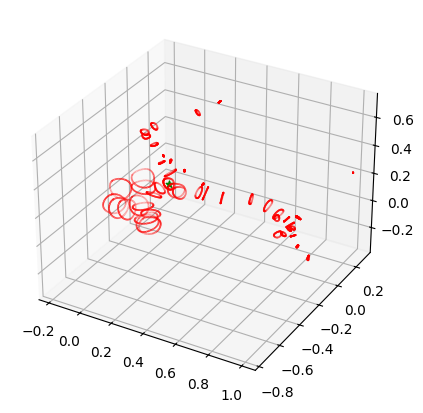

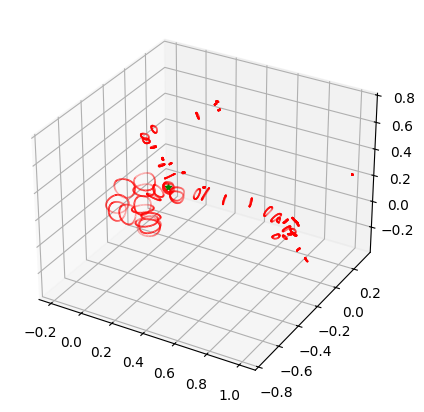

In [13]:
from tree_viewer import draw_tree_splines
from tree_functions import deserialize_pre_order_k
serial = list(original.flatten())
print("original", serial)
tree, _ = deserialize_pre_order_k(serial, k = 39)
draw_tree_splines(tree)
serial = list(generado.flatten())
print("generado", serial)
tree, _ = deserialize_pre_order_k(serial, k = 39)
draw_tree_splines(tree)

test para batch

In [37]:
from Stage1.modelsMultitalk.stage1Emma import VQAutoEncoder as VQbatch

checkpoint = torch.load("models/stage1/aneux+intra/best-model-nuevoquant-zeroroot-hidden512-cb2048.pth")

#checkpoint = torch.load("modelos-entrenados/elated-surf.pth", map_location= "cuda:0")
modelbatch = VQbatch(args, hidden_dim=512, codebook_size=2048).to(device)
modelbatch.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['loss']
print(checkpoint['epoch'])

501


In [ ]:
arboles_generados = {}
i=0
for input, file_name in val_loader:
    with torch.no_grad():  # No need to compute gradients during sampling
        if input.shape[1] > 1:
            input = input.to(device)
            generated_tree, quantized_tree = modelbatch.sample_step(input.to(device))
            arboles_generados[file_name] = generated_tree
            i+=1
            #if i>100:
            #    break


Column-wise min: tensor([[-0.7137, -0.0976, -0.5283, -0.7164, -0.7164, -0.7164, -0.7164, -0.7164,
         -0.7164, -0.7164, -0.7164, -0.0113, -0.1486, -0.1478, -0.0113, -0.1486,
         -0.1478, -0.1478, -0.1478, -0.5310, -0.5310, -0.5310, -0.5310, -0.5310,
         -0.5310, -0.5310, -0.5310, -3.0000, -2.0000, -1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
Column-wise max: tensor([[0.7034, 0.9922, 0.3212, 0.7153, 0.7153, 0.7153, 0.7153, 0.7153, 0.7153,
         0.7153, 0.7153, 0.9868, 0.9868, 0.9868, 0.9868, 0.9868, 0.9868, 0.9868,
         0.9868, 0.3135, 0.3135, 0.3135, 0.3135, 0.3135, 0.3135, 0.3135, 0.3135,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 4.0000,
         4.0000, 4.0000, 4.0000]])
Column-wise min: tensor([], size=(0, 39))
Column-wise max: tensor([], size=(0, 39))
Column-wise min: tensor([[-3., -2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
Column-wise max: tensor([], size=(0, 

In [43]:
arboles_generados

{('Data\\Aneux+Intra-splines\\p15\\SNF00000063-ane.npy',): tensor([[[ 3.4573e-01, -5.7497e-01,  1.9009e-01,  ...,  2.1390e+00,
            2.1539e+00,  2.2163e+00],
          [ 5.7141e-01, -5.1654e-01,  2.6624e-01,  ...,  2.0638e+00,
            2.1047e+00,  2.1427e+00],
          [-9.1729e-04,  1.9595e-04,  1.5233e-04,  ..., -3.2483e-04,
           -1.1255e-03, -1.3314e-03],
          ...,
          [-5.9571e-01,  5.0350e-01, -8.8803e-01,  ...,  1.4488e+00,
            1.5837e+00,  1.7038e+00],
          [-4.2083e-04,  8.5598e-04,  2.2221e-04,  ...,  8.8513e-05,
           -9.6363e-04, -9.4767e-04],
          [-1.8345e-04,  8.4229e-06,  2.2523e-05,  ...,  1.2402e-04,
           -1.0058e-03, -1.3281e-03]]], device='cuda:0'),
 ('Data\\Aneux+Intra-splines\\p15\\ArteryObjAN27-5-intra.npy',): tensor([[[-6.4779e-01,  3.7674e-01, -2.2291e-01,  ...,  1.9628e+00,
            2.0128e+00,  2.0589e+00],
          [-2.5732e-01,  2.4173e-01, -1.3441e-01,  ...,  1.0490e+00,
            1.2692e+00,  

In [44]:
#original = np.load("./Data/AneuxSplines/zero-root/p15/val/C0017.npy").reshape(-1, 39)
original = np.load('Data\\Aneux+Intra-splines\\p15\\ArteryObjAN27-5-intra.npy').reshape(-1, 39)
generado = arboles_generados[('Data\\Aneux+Intra-splines\\p15\\ArteryObjAN27-5-intra.npy',)].cpu().detach().numpy().squeeze(0)
generado [abs(generado)<1e-2] = 0
print(original.shape, generado.shape)

(39, 39) (39, 39)


In [45]:
print(original[0])
print(generado[0])

[-0.58259189  0.3390578  -0.1716339  -0.58029574 -0.63471222 -0.51923943
 -0.58029574 -0.63471222 -0.51923943 -0.51923943 -0.51923943  0.35154563
  0.32407522  0.34049252  0.35154563  0.32407522  0.34049252  0.34049252
  0.34049252 -0.13725196 -0.22390552 -0.15359913 -0.13725196 -0.22390552
 -0.15359913 -0.15359913 -0.15359913 -1.         -0.57206208 -0.28317481
  0.          0.42793792  0.71682519  1.          1.42793798  1.71682525
  2.          2.          2.        ]
[-0.6477852   0.37674093 -0.22290888 -0.60665727 -0.5963434  -0.5905211
 -0.6090249  -0.60955083 -0.6066939  -0.59981    -0.61321217  0.39456633
  0.39263806  0.40344313  0.39759475  0.37273288  0.3959807   0.39474553
  0.39832696 -0.19481403 -0.1963855  -0.18730927 -0.18085983 -0.18362843
 -0.19415808 -0.1827397  -0.17532171 -0.89245003 -0.6167088  -0.2629683
  0.          0.49266395  0.76704305  1.0494792   1.4043665   1.6552432
  1.962753    2.0127733   2.0589125 ]


In [46]:
for file_name, generated_tree in arboles_generados.items():
    generado = generated_tree.cpu().detach().numpy()[0]
    generado [abs(generado)<1e-2] = 0
    np.save("generated/clean/val/"+file_name[0], np.array(generado))

FileNotFoundError: [Errno 2] No such file or directory: 'generated/clean/val/Data\\Aneux+Intra-splines\\p15\\SNF00000063-ane.npy'

original [-0.5825918912887573, 0.3390578031539917, -0.17163389921188354, -0.580295741558075, -0.6347122192382812, -0.5192394256591797, -0.580295741558075, -0.6347122192382812, -0.5192394256591797, -0.5192394256591797, -0.5192394256591797, 0.35154563188552856, 0.32407522201538086, 0.34049251675605774, 0.35154563188552856, 0.32407522201538086, 0.34049251675605774, 0.34049251675605774, 0.34049251675605774, -0.13725195825099945, -0.2239055186510086, -0.15359912812709808, -0.13725195825099945, -0.2239055186510086, -0.15359912812709808, -0.15359912812709808, -0.15359912812709808, -1.0, -0.572062075138092, -0.2831748127937317, 0.0, 0.42793792486190796, 0.7168251872062683, 1.0, 1.4279379844665527, 1.716825246810913, 2.0, 2.0, 2.0, -0.5565201044082642, 0.43866488337516785, -0.20073866844177246, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, -0.5565201044082642, 0.43866488337516785, 0.438664883375

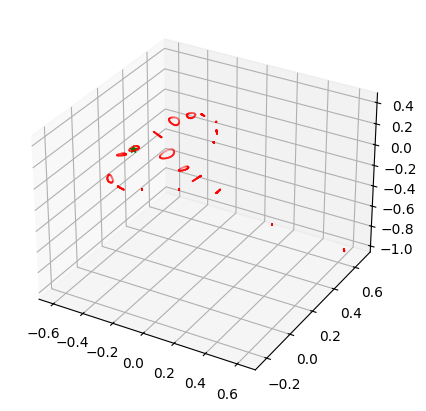

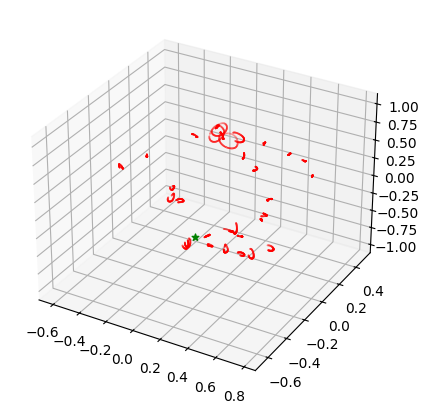

In [47]:
from tree_viewer import draw_tree_splines
from tree_functions import deserialize_pre_order_k
serial = list(original.flatten())
print("original", serial)
tree, _ = deserialize_pre_order_k(serial, k = 39)
draw_tree_splines(tree)
serial = list(generado.flatten())
print("generado", serial)
tree, _ = deserialize_pre_order_k(serial, k = 39)
draw_tree_splines(tree)

In [19]:
p

NameError: name 'p' is not defined

In [ ]:
h = np.load("Data/AneuxSplines/p20/train/C0002.npy")
print(h)
print(h[0])
print(h[-1])

[ 0.20150365 -0.08272542 -0.3654407  ...  0.          0.
  0.        ]
0.20150364935398102
0.0


In [ ]:
h = np.load("Data/AneuxSplines/train/C0002.npy")
print(h[0])
print(h[-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.20150365 -0.08272542 -0.3654407   0.17331345  0.04043995  0.24810071
  0.35511416  0.17331345  0.04043995  0.24810071  0.24810071  0.04569183
 -0.08664371 -0.21176979 -0.0788658   0.04569183 -0.08664371 -0.21176979
 -0.21176979 -0.26458544 -0.43617177 -0.45915538 -0.29787511 -0.26458544
 -0.43617177 -0.45915538 -0.45915538 -0.75687188 -0.49808204 -0.23247024
  0.          0.24312812  0.50191796  0.76752979  1.          1.24312806
  1.50191796  1.76752973  1.76752973]


In [ ]:

generado = generated_tree.cpu().detach().numpy()[0]
#generado[generado<1e-2] = 0
for i, row in enumerate(generado):
    if np.mean(row)<0.1:
        generado[i] = [0.]*39

serializado = ''
j = 0
for array in generado :
    #print(np.mean(array))
    if (np.mean(array)<0.1):
        #string = "#;"
        string = str(00)+"_"+str([0.]*39)+";"
    else:
        string = str(j)+"_"+str([float(val) for val in array])+";"
    serializado += string
    j+=1
serializado = serializado[:-1]

tree, ret = deserialize_pre_order(serializado)
print(tree.data)
#serial_tree = serialize_post_order(tree)
#print("ser", serial_tree)
#vector = []
#traversefeaturesSerializado(tree, vector)
#data_np = np.array(vector).reshape((-1,39))
vec = serialize_post_order_numpy_vector(tree)
vec = vec[:, ::-1]
#np.save("reconstruido.npy", np.array(vec))


defaultdict(<class 'list'>, {'r': ['0.2406897246837616', ' 0.10768366605043411', ' 0.128645658493042', ' 0.26360276341438293', ' 0.260517954826355', ' 0.24568620324134827', ' 0.2434486746788025', ' 0.2530868947505951', ' 0.2597881257534027', ' 0.2501109838485718', ' 0.25485873222351074', ' 0.0962001383304596', ' 0.09795036166906357', ' 0.09732997417449951', ' 0.09644563496112823', ' 0.09981262683868408', ' 0.10757671296596527', ' 0.10786186158657074', ' 0.10966445505619049', ' 0.12993231415748596', ' 0.12819631397724152', ' 0.14675240218639374', ' 0.12041275203227997', ' 0.12569580972194672', ' 0.13554464280605316', ' 0.15084388852119446', ' 0.1243901401758194', ' -2.9977328777313232', ' -1.9684441089630127', ' -0.9813185930252075', ' -0.012125164270401001', ' 0.9799285531044006', ' 1.9697473049163818', ' 2.997701644897461', ' 3.9958012104034424', ' 4.009079933166504', ' 3.999335765838623', ' 3.996771812438965', ' 4.003289699554443']})


In [ ]:
vec.shape

(83, 39)

In [ ]:
def traversefeaturesSerializado(root, features):
    def post_order(root, features):
        if root:
            post_order(root.left, features)
            post_order(root.right, features)
            features.append(root.data['r'])
                
        #else:
        #    features.append(torch.tensor([0.,0.,0.,0.]))           

    post_order(root, features)
    return features[:-1]  # remove last ,


In [ ]:
#paso el original de nuevo a post order y recien guardo


In [ ]:
def serialize_pre_order(tree):

    if tree == None: return [[0.0] * 39]
    return list(tree.data.values())[::-1] + serialize_pre_order(tree.left) + serialize_pre_order(tree.right)


#imito lo que hace el dataloader
file_path = os.path.join("aneuriskeps02-splines", "0023.npy")

# Use memory mapping to avoid loading full file into memory
tree_data_np = np.load(file_path, mmap_mode='r')
print(tree_data_np[10])
# Convert to tensor only when accessed
tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)
serial_tree = list(tree_tensor.flatten().numpy())
tree = deserialize_post_order(serial_tree)
serial_tree = serialize_pre_order(tree)
np_tree = np.array(serial_tree).reshape((-1,39))
tree_tensor = torch.tensor(np_tree, dtype = torch.float32)

FileNotFoundError: [Errno 2] No such file or directory: 'aneuriskeps02-splines\\0023.npy'

In [ ]:
inverted_matrix = vec[:, ::-1]
inverted_matrix[28]

array([10.1394    , 35.3011    , 37.374     ,  9.376549  , 10.402729  ,
       10.858492  , 10.730822  , 10.298035  ,  9.376549  , 10.402729  ,
       10.858492  , 35.945934  , 34.36231   , 35.15412   , 35.670475  ,
       35.934864  , 35.945934  , 34.36231   , 35.15412   , 37.228184  ,
       37.790913  , 37.275635  , 37.04219   , 37.01137   , 37.228184  ,
       37.790913  , 37.275635  , -0.6907999 , -0.4968771 , -0.271366  ,
        0.        ,  0.14701131,  0.3092001 ,  0.50312287,  0.728634  ,
        1.        ,  1.1470113 ,  1.3092002 ,  1.5031229 ], dtype=float32)

In [ ]:
(vec-tree_data_np)[28]

array([-0.65181637,  0.02259827,  0.26686478,  0.00751444, -0.76691042,
       -0.91783524, -0.78332189, -0.30374679,  0.01853987, -0.75374113,
       -0.62802506,  0.47813368,  0.62708841,  0.00630699, -0.20869379,
       -0.00487521,  0.40888166,  0.58681284, -0.06428017,  0.52448611,
        0.31609588,  0.63323269,  0.61726998,  0.61233125,  0.51628832,
        0.09720092,  0.6363493 ,  0.03551185,  0.01456709,  0.15820164,
       -0.14192291,  0.02141976,  0.03615614,  0.05341003,  0.02659137,
       -0.00402635,  0.01159652,  0.06785994,  0.03147797])

In [ ]:
i=0
import traceback
for file_name, generated_tree in arboles_generados.items():
    i+=1
    generado = generated_tree.cpu().detach().numpy()[0]
    #generado[generado<1e-2] = 0
    for i, row in enumerate(generado):
        if np.mean(row)<0.1:
            generado[i] = [0.]*39

    serializado = ''
    j = 0
    try:
        for array in generado :
            #print(np.mean(array))
            if (np.mean(array)<0.1):
                #string = "#;"
                string = str(00)+"_"+str([0.]*39)+";"
            else:
                string = str(j)+"_"+str([float(val) for val in array])+";"
            serializado += string
            j+=1
        serializado = serializado[:-1]

        tree, ret = deserialize_pre_order(serializado)
        vec = serialize_post_order_numpy_vector(tree)
        vec = vec[:, ::-1]
        np.save(file_name[0], np.array(vec))
        # Use memory mapping to avoid loading full file into memory
        tree_data_np = np.load("stage1-augmented/train/"+ file_name[0], mmap_mode='r')
        print(tree_data_np[10])
        # Convert to tensor only when accessed
        tree_tensor = torch.tensor(tree_data_np, dtype=torch.float32)
        serial_tree = list(tree_tensor.flatten().numpy())
        tree = deserialize_post_order(serial_tree)
        serial_tree = serialize_pre_order(tree)
        np_tree = np.array(serial_tree).reshape((-1,39))
        tree_tensor = torch.tensor(np_tree, dtype = torch.float32)
    except:
        i+=1
        print(f"no compila {file_name[0]}")
        traceback.print_exc()
    if i>0:
        break

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
